# Fantasy Points Prediction Model *by Antonio Nardi*

## Goal

The goal of this project is to create a model that will predict the amount of fantasy points a player will produce, given certain non related-variables. A non-related variable is a variable that doesn't directly affect the base fantasy league's formula for points. Which includes variables that directly result in a goal or an assist.

# Setup

## Installs

In [1]:
!pip install html5lib -q
!pip install statsmodels -q
!pip install pandas -q
!pip install numpy -q
!pip install seaborn -q
!pip install scikit-learn -q
!pip install matplotlib -q

## Imports

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time
from functools import reduce

# Data

## Define SeasonData Object

In [3]:
class SeasonsData:
    def __init__(self, years):
        self.years = years
        self.season_tables = {year: self.get_season_tables(year) for year in self.years}
        self.season_datasets = {year: self.get_season_datasets(self.season_tables[year]) for year in self.years}
        self.complete_dataset =  self.get_complete()
        self.shape = self.complete_dataset.shape
        
    def get_season_tables(self, year):
        """
        Get each table from hockey-reference
        season databases
        """

        # -- Define URLS --

        ref_url = 'https://www.hockey-reference.com'

        basic_ext = f'/leagues/NHL_{year}_skaters.html'
        adv_ext = f'/leagues/NHL_{year}_skaters-advanced.html'
        shift_ext = f'/leagues/NHL_{year}_skaters-time-on-ice.html'
        
        #### HAD TO REMOVE MISC BECAUSE IT WASNT TRACKED FOR MOST YEARS
        # misc_ext = f'/leagues/NHL_{year}_skaters-misc.html'

        url_names = ['basic', 'adv', 'shift',]
        url_ext = [basic_ext, adv_ext, shift_ext]

        # --- Get Tables ---

        raw_tables = {}
        print(f'Grabbing {year} season data')
        for name, ext in zip(url_names, url_ext):
            req = False
            fails = 0
            while req == False:
                sleep_time = 2**fails
                try:
                    df = pd.read_html(ref_url+ext)[0].apply(lambda x: x.astype(str).str.upper())
                    req = True
                except:
                    fails += 1
                    print(fails, 'fails')
                    time.sleep(sleep_time)
                    pass
            li = list(df.columns)
            col = [ x[1] for x in li ]
            df.columns = col
            df = df[df['Rk'] != 'RK'].reset_index(drop=True).sort_values(by='Player')
            tot_tm = df[df['Tm'] == 'TOT']
            no_dupes = df.drop_duplicates(subset='Player', keep=False)
            df = pd.concat([no_dupes, tot_tm])
            df_dict = {name: df}
            raw_tables.update(df_dict)
            print(f'- Grabbed {name}')
        
        return raw_tables

    def get_season_datasets(self, raw_tables):
        """
        Cleans columns of each dataframe and 
        merges all dataframes into one complete 
        dataframe
        """

        # Basic Dataframe
        basic_df = raw_tables['basic'].drop(['FO%'], axis=1)
        basic_df.columns =    [
                                'Rk', 'Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM',
                                'PS', 'EV_G', 'PP_G', 'SH_G', 'GW_G', 'EV_A', 'PP_A', 'SH_A', 'S', 'S%', 'TOI',
                                'ATOI', 'BLK', 'HIT', 'FOW', 'FOL'
                            ]
        raw_tables['basic'] = basic_df

        # Adv Dataframe
        adv_df = raw_tables['adv'].drop(['GP', 'Age', 'Rk', 'Pos'], axis=1)
        try:
            adv_df = adv_df.drop(['E+/-'], axis=1)
        except:
            pass
        adv_df.columns =    [
                                'Player', 'Tm', 'CF', 'CA', 'CF%', 'CF% rel',
                                'FF', 'FA', 'FF%', 'FF% rel', 'oiSH%', 'oiSV%', 'PDO', 'oZS%', 'dZS%',
                                'TOI/60', 'TOI(EV)', 'TK', 'GV', 'SAtt.', 'Thru%'
                            ]
        raw_tables['adv'] = adv_df

        # Shift Dataframe
        shift_df = raw_tables['shift'].drop([
            'GP', 'Unnamed: 6_level_1', 'Unnamed: 11_level_1', 'Unnamed: 16_level_1', 'Rk', 'Pos'
        ], axis=1)
        shift_df.columns =  [
                                'Player', 'Tm', 'Shift', 'TOI_EVEN',
                                'CF% Rel_EVEN', 'GF/60_EVEN', 'GA/60_EVEN', 'TOI_PP', 'CF% Rel_PP',
                                'GF/60_PP', 'GA/60_PP', 'TOI_SH', 'CF% Rel_SH', 'GF/60_SH',
                                'GA/60_SH'
                            ]
        raw_tables['shift'] = shift_df
        
        #### HAD TO REMOVE MISC BECAUSE IT WASNT TRACKED FOR MOST YEARS
        # Misc Dataframe
        # misc_df = raw_tables['misc'].drop([
        #     'GP', 'Age', 'Made', 'Miss', 'Pct.', 'Rk', 'Pos', '+/-', 'PS'
        # ], axis=1)
        # try:
        #     misc_df = misc_df.drop(['xGF', 'xGA', 'E+/-'], axis=1)
        # except:
        #     pass
        # misc_df.columns  =  [
        #                         'Player', 'Tm', 'GC', 'G_PG', 'A_PG', 'PTS_PG', 'GC_PG',
        #                         'PIM_PG', 'S_PG', 'G_ADJ', 'A_ADJ', 'PTS_ADJ', 'GC_ADJ', 'TGF', 'PGF', 
        #                         'TGA', 'PGA', 'OPS', 'DPS', 'Att.'
        #                     ]
        # raw_tables['misc'] = misc_df

        # Full Dataframe
        full_data = reduce(
            lambda  left,right: pd.merge(
                left,right,on=['Player', 'Tm'],
                how='outer'
            ), [ raw_tables[x] for x in raw_tables.keys() ]
        ).drop_duplicates(subset='Player', keep='first').dropna(subset=['Pos'])
        
        full_data = full_data.replace({
            'C': 'F', 
            'LW': 'F', 
            'RW': 'F', 
            'W': 'F', 
            'NAN': np.nan, 
            '': np.nan
        }).dropna()
        
        # --- Calculate Fantasy Points ---

        g_pts = 3
        a_pts = 2
        pp_pts = 1
        sh_pts = 2
        hat_pts = 1
        sog_pts = 0.1
        hts_pts = 0.1
        blk = 0.2
        
        full_data['FTSY_PTS'] = round(sum([
            (full_data['G'].astype(int)*g_pts), 
            (full_data['A'].astype(int)*a_pts), 
            (full_data['PP_G'].astype(int)*pp_pts), 
            (full_data['SH_G'].astype(int)*sh_pts), 
            # (full_data['HAT']*hat_pts), 
            (full_data['S'].astype(int)*sog_pts), 
            (full_data['HIT'].astype(int)*hts_pts), 
            (full_data['BLK'].astype(int)*blk)
        ]),1)

        return full_data
    
    def get_sec(self, time_str):
        """Get seconds from minutes and seconds."""
        m, s = time_str.split(':')
        return float(int(m) * 60 + int(s))
    
    def get_complete(self):
        complete_df = pd.concat(self.season_datasets.values()).drop(['Rk'], axis=1)
        
        for col in complete_df:
            first = complete_df.loc[0, col].tolist()[0]
            try:
                float(first)
                complete_df[col] = complete_df[col].astype(float)
            except:
                complete_df[col] = complete_df[col].astype(str)
        
        time_cols = ['ATOI', 'TOI/60', 'TOI(EV)', 'Shift', 'TOI_EVEN', 'TOI_PP', 'TOI_SH']
        for col in time_cols:
            complete_df[col] = complete_df[col].apply(lambda time_str: self.get_sec(time_str))
        
        return complete_df.reset_index(drop=True)
    
    def __repr__(self):
        return repr(self.complete_dataset)

## Initialize SeasonData Object

Getting player data from 2008 to the present day would be the ideal dataset, but I keep getting an error:
``` Python
HTTPError: HTTP Error 429: Too Many Requests
```
To get arround this, I will be using a smaller dataset.

In [4]:
years = list(range(2014, datetime.date.today().year))
data = SeasonsData(years)

Grabbing 2014 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2015 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2016 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2017 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2018 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2019 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2020 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2021 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift
Grabbing 2022 season data
- Grabbed basic
- Grabbed adv
- Grabbed shift


## Test Attributes and Methods

In [5]:
data.shape

(4880, 59)

59 columns

In [6]:
data.complete_dataset.query('Player == "CONNOR MCDAVID"')

,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,PS,EV_G,PP_G,SH_G,GW_G,EV_A,PP_A,SH_A,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,CF,CA,CF%,CF% rel,FF,FA,FF%,FF% rel,oiSH%,oiSV%,PDO,oZS%,dZS%,TOI/60,TOI(EV),TK,GV,SAtt.,Thru%,Shift,TOI_EVEN,CF% Rel_EVEN,GF/60_EVEN,GA/60_EVEN,TOI_PP,CF% Rel_PP,GF/60_PP,GA/60_PP,TOI_SH,CF% Rel_SH,GF/60_SH,GA/60_SH,FTSY_PTS
720,CONNOR MCDAVID,19.0,EDM,F,45.0,16.0,32.0,48.0,-1.0,18.0,5.8,13.0,3.0,0.0,5.0,21.0,11.0,0.0,105.0,15.2,850.0,1133.0,10.0,12.0,249.0,355.0,709.0,629.0,53.0,6.2,529.0,472.0,52.8,6.9,10.5,87.7,98.2,53.5,46.5,1133.0,896.0,33.0,17.0,156.0,67.3,42.0,908.0,6.2,3.7,3.7,177.0,5.7,8.3,0.5,46.0,7.1,0.0,3.8,128.7
1315,CONNOR MCDAVID,20.0,EDM,F,82.0,30.0,70.0,100.0,27.0,26.0,12.8,26.0,3.0,1.0,6.0,45.0,24.0,1.0,251.0,12.0,1733.0,1268.0,29.0,34.0,348.0,458.0,1479.0,1272.0,53.8,5.6,1112.0,917.0,54.8,5.6,10.9,91.0,101.9,56.2,43.8,1268.0,1031.0,76.0,54.0,420.0,59.8,51.0,1037.0,5.6,3.7,2.6,182.0,-1.9,9.8,0.9,48.0,-2.6,1.8,7.3,269.3
1912,CONNOR MCDAVID,21.0,EDM,F,82.0,41.0,67.0,108.0,20.0,26.0,13.1,35.0,5.0,1.0,7.0,49.0,15.0,3.0,274.0,15.0,1767.0,1293.0,46.0,28.0,376.0,533.0,1643.0,1442.0,53.3,3.8,1259.0,1066.0,54.2,4.4,10.5,90.5,100.9,55.6,44.4,1292.0,1038.0,111.0,67.0,433.0,63.5,58.0,1049.0,3.8,4.0,3.2,177.0,1.3,5.3,1.0,65.0,5.8,3.0,6.1,303.4
2490,CONNOR MCDAVID,22.0,EDM,F,78.0,41.0,75.0,116.0,3.0,20.0,13.0,31.0,9.0,1.0,9.0,50.0,24.0,1.0,240.0,17.1,1781.0,1370.0,30.0,39.0,428.0,490.0,1466.0,1436.0,50.5,3.8,1110.0,1109.0,50.0,3.3,12.2,88.5,100.7,57.2,42.8,1370.0,1127.0,99.0,89.0,422.0,56.6,55.0,1127.0,3.8,4.0,3.8,205.0,8.1,9.4,0.7,37.0,13.7,3.7,12.3,317.9
3070,CONNOR MCDAVID,23.0,EDM,F,64.0,34.0,63.0,97.0,-6.0,28.0,10.9,23.0,11.0,0.0,6.0,31.0,32.0,0.0,212.0,16.0,1399.0,1312.0,18.0,37.0,320.0,350.0,1049.0,1118.0,48.4,1.0,819.0,872.0,48.4,-0.1,11.4,89.3,100.7,57.5,42.5,1312.0,1051.0,53.0,75.0,339.0,62.5,52.0,1072.0,1.0,3.7,3.7,233.0,-2.3,12.4,1.9,6.0,-10.5,0.0,2.7,267.5
3681,CONNOR MCDAVID,24.0,EDM,F,56.0,33.0,72.0,105.0,21.0,20.0,13.0,24.0,9.0,0.0,11.0,44.0,28.0,0.0,200.0,16.5,1241.0,1329.0,24.0,61.0,316.0,322.0,1066.0,865.0,55.2,10.5,810.0,667.0,54.8,9.8,12.1,89.1,101.2,62.4,37.6,1329.0,1069.0,36.0,47.0,314.0,63.7,57.0,1071.0,10.5,4.5,3.2,251.0,6.9,11.9,1.0,6.0,39.1,0.0,0.0,282.9
4305,CONNOR MCDAVID,25.0,EDM,F,80.0,44.0,79.0,123.0,28.0,45.0,14.0,34.0,10.0,0.0,9.0,44.0,34.0,1.0,314.0,14.0,1765.0,1324.0,26.0,75.0,562.0,484.0,1670.0,1265.0,56.9,7.2,1278.0,987.0,56.4,7.9,10.1,91.0,101.1,56.3,43.7,1324.0,1088.0,73.0,68.0,481.0,65.5,59.0,1088.0,7.2,4.0,2.7,223.0,5.1,10.7,0.8,12.0,6.2,3.7,3.7,344.1


# Preprocess Data

The X dataframe is the independant variable and y is the dependent variable.

In [7]:
dataset = data.complete_dataset

# Inputs
X = dataset.drop(['Player', 'Tm'], axis=1)

# Output
y = dataset['FTSY_PTS']

## Preprocess X

### Drop Variables associated with FTSY_PTS

The goal of this model is to not rely on the variables, which are directly connected to the production of points (fantasy system). Thus, I removed the variables which are connected to the fantasy points formula: goals, assists, power play goals, power play assists, short handed goals, short handed assists, even goals, even assists, points share, game winning goals, blocks, hits, points (nhl system).

In [8]:
to_drop = [
    'G', 'A', 'PP_G','SH_G', 'GW_G', 'EV_G', 'PS',
    'PP_A', 'SH_A', 'BLK','HIT', 'EV_A', 'PTS','S%'
]
X = X.drop(to_drop, axis=1)

### Get Dummies For Pos Column

Since, we cannot input categorical variables into the model, I created columns which determines the player's position as a 1 or 0. We drop the first column after creating dummies, to achieve this and to avoid any problems. The value than I dropped will get absorbed into the constant.

In [9]:
posd = pd.get_dummies(X.Pos, drop_first=True)
X = pd.concat([X, posd],axis=1).drop(['Pos'], axis=1)

### Add Polynomial Features

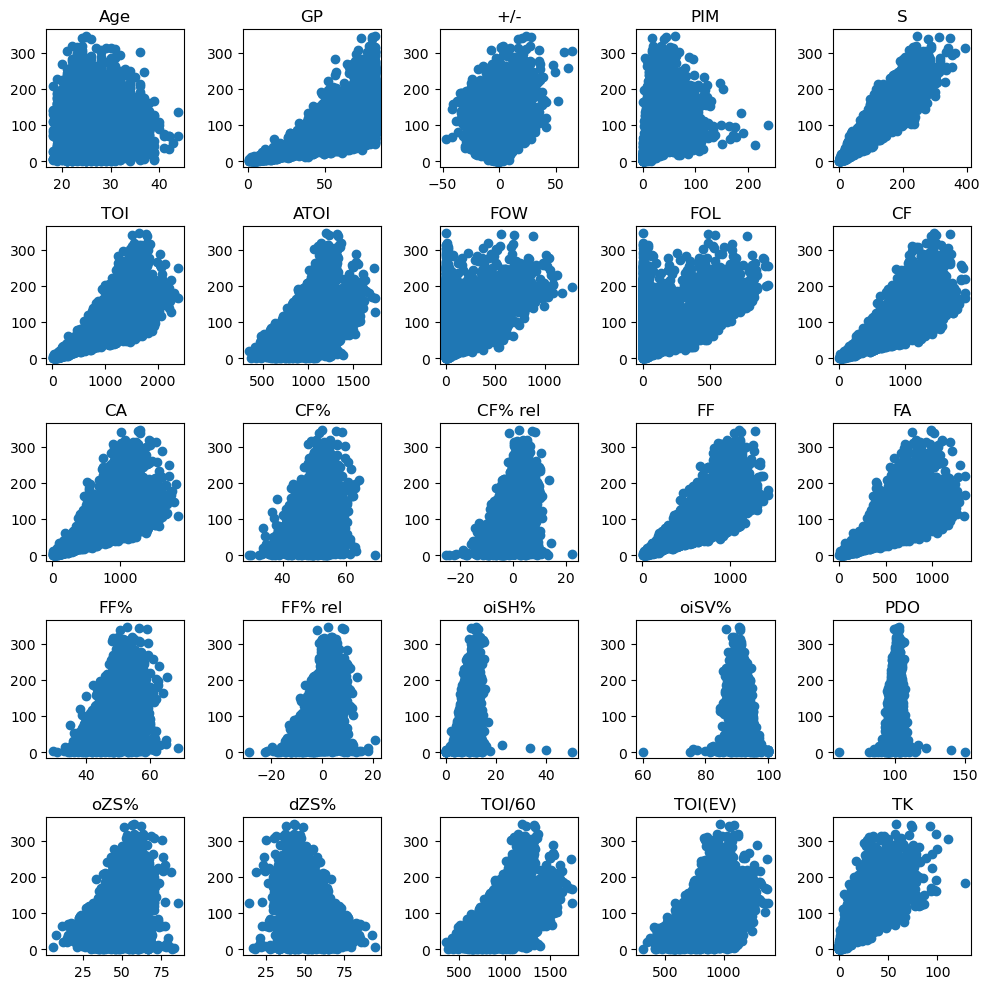

In [10]:
fig, ax = plt.subplots(5,5, figsize=(10,10))

cols = X.columns
col_idx = 0
for i1 in range(5):
    for i2 in range(5):
        ax[i1,i2].scatter(X[cols[col_idx]], y)
        ax[i1,i2].set_title(cols[col_idx])
        col_idx+=1
        
fig.tight_layout()

By looking at the scatter plots, it seems like a polynomial will fit better in some cases. I'll add second degree polynomial features to the data.

In [11]:
degree = 2
for col in X:
    X[col+f'_{degree}'] = X[col] ** degree

### Drop Highly Correlated Columns

To avoid bad p-values off the start, I'm removing highly correlated variables (correlation coefficient over 0.8).

<AxesSubplot:>

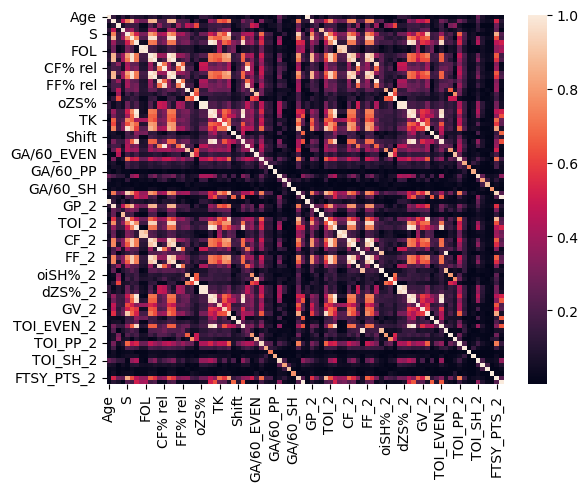

In [12]:
sns.heatmap(X.corr().abs())

In [13]:
# Drop highly correlated values
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.8)]
X = X.drop(to_drop, axis=1)

print('Dropped: \n', to_drop)

Dropped: 
 ['TOI', 'FOL', 'CF', 'CA', 'FF', 'FA', 'FF%', 'FF% rel', 'dZS%', 'TOI/60', 'TOI(EV)', 'GV', 'SAtt.', 'TOI_EVEN', 'CF% Rel_EVEN', 'GF/60_EVEN', 'GA/60_EVEN', 'FTSY_PTS', 'Age_2', 'GP_2', 'PIM_2', 'S_2', 'TOI_2', 'ATOI_2', 'FOW_2', 'FOL_2', 'CF_2', 'CA_2', 'CF%_2', 'FF_2', 'FA_2', 'FF%_2', 'FF% rel_2', 'oiSH%_2', 'oiSV%_2', 'PDO_2', 'oZS%_2', 'dZS%_2', 'TOI/60_2', 'TOI(EV)_2', 'TK_2', 'GV_2', 'SAtt._2', 'Thru%_2', 'Shift_2', 'TOI_EVEN_2', 'CF% Rel_EVEN_2', 'GF/60_EVEN_2', 'GA/60_EVEN_2', 'TOI_PP_2', 'CF% Rel_PP_2', 'GA/60_PP_2', 'TOI_SH_2', 'CF% Rel_SH_2', 'GF/60_SH_2', 'FTSY_PTS_2', 'F_2']


/tmp/ipykernel_56729/591815908.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


### Normalize Data

There are big differences in the data, in terms of scale and ranges. To combat this, I decided to normalize the data

In [14]:
X_norm = preprocessing.normalize(X)
X = pd.DataFrame(X_norm, columns =list(X.columns))

## Preprocess Y

Text(0.5, 1.0, 'Log Treated')

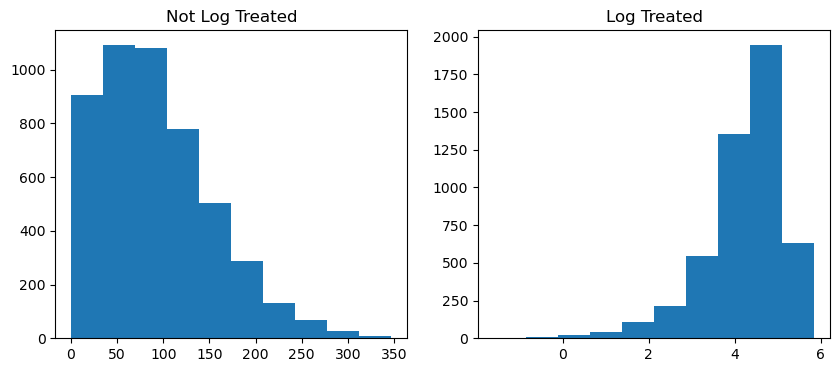

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.hist(y)
ax1.set_title('Not Log Treated')
ax2.hist(np.log(y))
ax2.set_title('Log Treated')

After looking at the distribution of dependent variable, it is clear that the mean is skewed to one side. To help achieve a distribution which is closer to a normal distribution, I decided to use np.log.

In [16]:
y = np.log(y)

# OLS Model

## Split Data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit Model

Adding a constant to X will help the fit.

In [18]:
model_ols = sm.OLS(y_train, sm.add_constant(X_train)).fit(cov_type='HC3')
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FTSY_PTS   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     621.0
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:48:40   Log-Likelihood:                -1583.2
No. Observations:                3904   AIC:                             3226.
Df Residuals:                    3874   BIC:                             3414.
Df Model:                          29                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8543      0.258     14.933      0.000       3.348       4.360
Age            2.8389      1.705      1.665      0.096      -0.502       6.180
GP            19.1086      0.909     21.020      0.000      17.327      20.890
+/-            9.8630      2.386      4.133      0.000       5.186      14.540
PIM            0.9812      0.244      4.025      0.000       0.503       1.459
S              4.1820      0.372     11.249      0.000       3.453       4.911
ATOI           0.8932      0.351      2.548      0.011       0.206       1.580
FOW            0.1893      0.074      2.550      0.011       0.044       0.335
CF%           -7.3045      2.883     -2.533      0.011     -12.956      -1.653
CF% rel        1.8274      4.587      0.398      0.690      -7.164      10.819
oiSH%       -198.8090    112.402     -1.769      0.077    -419.114      21.496
oiSV%       -242.2822    112.430     -2.155      0.031    -462.641     -21.923
PDO          218.7649    112.564      1.943      0.052      -1.856     439.385
oZS%          -1.9812      1.366     -1.450      0.147      -4.658       0.696
TK             0.3948      0.528      0.748      0.454      -0.639       1.429
Thru%          2.3633      2.037      1.160      0.246      -1.629       6.356
Shift         -0.3463      0.891     -0.389      0.698      -2.093       1.401
TOI_PP         0.8897      0.304      2.926      0.003       0.294       1.486
CF% Rel_PP    -0.3757      0.469     -0.802      0.423      -1.294       0.543
GF/60_PP      20.5895      4.398      4.682      0.000      11.970      29.209
GA/60_PP       1.5992      1.805      0.886      0.376      -1.939       5.138
TOI_SH        -0.6796      0.439     -1.549      0.121      -1.540       0.180
CF% Rel_SH     0.1573      0.565      0.278      0.781      -0.950       1.265
GF/60_SH       0.1260      1.129      0.112      0.911      -2.086       2.338
GA/60_SH       8.1050      4.154      1.951      0.051      -0.037      16.247
F            246.5392     46.484      5.304      0.000     155.432     337.646
+/-_2          0.3347      0.078      4.265      0.000       0.181       0.489
CF% rel_2     -1.7176      0.507     -3.389      0.001      -2.711      -0.724
GF/60_PP_2    -0.8096      0.269     -3.006      0.003      -1.337      -0.282
GA/60_SH_2    -0.3778      0.247     -1.527      0.127      -0.863       0.107
==============================================================================
Omnibus:                     2188.421   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43256.568
Skew:                          -2.252   Prob(JB):                         0.00
Kurtosis:                      18.673   Cond. No.                     4.82e+04
==============================================================================

N

In [19]:
y_pred = model_ols.predict(sm.add_constant(X_test))

y_test_real = np.exp(y_test)
y_pred_real = np.exp(y_pred)

mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = mean_squared_error(y_test_real, y_pred_real, squared=False)

print(f"Mean Absolute Error: {round(mae, 2)}")
print(f"Mean Squared Error: {round(mse, 2)}")
print(f"Root Mean Squared Error: {round(rmse, 2)}")

Mean Absolute Error: 16.64
Mean Squared Error: 598.73
Root Mean Squared Error: 24.47


# WLS Model

## Calculate Weights

To get the weights, I set fit a model using the residual and the fitted values. After that, the weight is simply the inverse of the cubed fitted values. The values are cubed because this give the best performing model according to the R-Squared, AIC and BIC.

In [20]:
weights = 1 / smf.ols('model_ols.resid.abs() ~ model_ols.fittedvalues', data=X_train).fit().fittedvalues**3

## Fit Model

In [21]:
model_wls = sm.WLS(y_train, sm.add_constant(X_train), weights=weights).fit(cov_type='HC3')
model_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               FTSY_PTS   R-squared:                       0.906
Model:                            WLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     724.9
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:48:40   Log-Likelihood:                -198.26
No. Observations:                3904   AIC:                             456.5
Df Residuals:                    3874   BIC:                             644.6
Df Model:                          29                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4476      0.160     27.729      0.000       4.133       4.762
Age           -1.1316      1.138     -0.994      0.320      -3.362       1.099
GP            12.6257      0.446     28.278      0.000      11.751      13.501
+/-            6.1982      0.479     12.935      0.000       5.259       7.137
PIM            1.2805      0.215      5.949      0.000       0.859       1.702
S              2.5416      0.144     17.653      0.000       2.259       2.824
ATOI           0.9270      0.157      5.890      0.000       0.618       1.235
FOW            0.2192      0.048      4.615      0.000       0.126       0.312
CF%           -5.6097      2.022     -2.775      0.006      -9.573      -1.647
CF% rel        0.6084      2.380      0.256      0.798      -4.057       5.273
oiSH%        -42.4620    102.216     -0.415      0.678    -242.802     157.878
oiSV%       -108.1977    102.084     -1.060      0.289    -308.279      91.883
PDO           81.3671    102.163      0.796      0.426    -118.868     281.602
oZS%          -0.7007      0.836     -0.839      0.402      -2.339       0.937
TK             1.9801      0.421      4.701      0.000       1.155       2.806
Thru%         -1.0735      1.119     -0.959      0.337      -3.267       1.120
Shift         -0.0226      0.788     -0.029      0.977      -1.567       1.522
TOI_PP         1.5612      0.179      8.736      0.000       1.211       1.911
CF% Rel_PP    -0.8214      0.367     -2.236      0.025      -1.541      -0.101
GF/60_PP      18.6592      3.455      5.401      0.000      11.888      25.430
GA/60_PP       3.3235      2.594      1.281      0.200      -1.761       8.408
TOI_SH        -0.2503      0.173     -1.448      0.148      -0.589       0.088
CF% Rel_SH     0.1043      0.289      0.362      0.718      -0.461       0.670
GF/60_SH       0.3806      0.980      0.389      0.698      -1.539       2.301
GA/60_SH       6.4306      2.617      2.457      0.014       1.302      11.560
F            300.0510     23.741     12.639      0.000     253.520     346.582
+/-_2          0.1608      0.052      3.074      0.002       0.058       0.263
CF% rel_2      0.2119      0.235      0.903      0.367      -0.248       0.672
GF/60_PP_2    -0.2668      0.213     -1.253      0.210      -0.684       0.150
GA/60_SH_2    -0.1556      0.155     -1.007      0.314      -0.459       0.147
==============================================================================
Omnibus:                      817.117   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4460.748
Skew:                          -0.888   Prob(JB):                         0.00
Kurtosis:                       7.926   Cond. No.                     5.61e+04
==============================================================================

N

This model has very respectable r-squared, aic and bic values, but there are multiple variables which are statistically insignificant. This means that there are potentially random elements added to the model.

In [22]:
y_pred = model_wls.predict(sm.add_constant(X_test))

y_test_real = np.exp(y_test)
y_pred_real = np.exp(y_pred)

mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = mean_squared_error(y_test_real, y_pred_real, squared=False)

print(f"Mean Absolute Error: {round(mae, 2)}")
print(f"Mean Squared Error: {round(mse, 2)}")
print(f"Root Mean Squared Error: {round(rmse, 2)}")

Mean Absolute Error: 12.59
Mean Squared Error: 299.05
Root Mean Squared Error: 17.29


Based on the evaluation metrics, the model's predicted values for a certain target variable have an average absolute error of 12.59 units, an average squared error of 299.05 squared units, and an average error of 17.29 units, measured in the same units as the target variable.

# Optimized WLS *(Insignificant Values Removed)*

## Remove Insignificant Variables

To build the best model, I used the p-values from the previous WLS model to remove statistically insignificant variables. Also, I removed a couple variables manually (Shift, ATOI, TOI_SH, GF/60_PP_2, GA/60_PP) while adjusting the current model (Optimized WLS) based on the p-values.

In [23]:
to_drop = (
    list(model_wls.pvalues[model_wls.pvalues > 0.05].index)
                           +
    ['Shift', 'ATOI', 'TOI_SH', 'GF/60_PP_2', 'GA/60_PP', 'CF% Rel_PP', 'GA/60_SH', '+/-_2', 'F']
)
X_opt = X.drop(to_drop, axis=1)


print('Dropped: \n', to_drop)

Dropped: 
 ['Age', 'CF% rel', 'oiSH%', 'oiSV%', 'PDO', 'oZS%', 'Thru%', 'Shift', 'GA/60_PP', 'TOI_SH', 'CF% Rel_SH', 'GF/60_SH', 'CF% rel_2', 'GF/60_PP_2', 'GA/60_SH_2', 'Shift', 'ATOI', 'TOI_SH', 'GF/60_PP_2', 'GA/60_PP', 'CF% Rel_PP', 'GA/60_SH', '+/-_2', 'F']


## Split New Data

Splitting the new dataset into training and test datasets.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_opt, y, test_size=0.2, random_state=42)

## Recalculate Weights

Since the data's shape changed, I recalculated the weights using a new OLS model.

In [25]:
model_ols_opt = sm.OLS(y_train, sm.add_constant(X_train)).fit(cov_type='HC3')
weights = 1 / smf.ols('model_ols_opt.resid.abs() ~ model_ols_opt.fittedvalues', data=X_train).fit().fittedvalues**4

In [26]:
model_opt = sm.WLS(y_train, sm.add_constant(X_train), weights=weights).fit(cov_type='HC3')
model_opt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               FTSY_PTS   R-squared:                       0.849
Model:                            WLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1310.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:48:40   Log-Likelihood:                -1193.1
No. Observations:                3904   AIC:                             2406.
Df Residuals:                    3894   BIC:                             2469.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6580      0.036    128.137      0.000       4.587       4.729
GP             8.2144      0.555     14.795      0.000       7.126       9.303
+/-           10.1939      0.606     16.828      0.000       9.007      11.381
PIM            1.5471      0.229      6.765      0.000       1.099       1.995
S              3.5920      0.146     24.535      0.000       3.305       3.879
FOW            0.2642      0.028      9.302      0.000       0.209       0.320
CF%          -32.0138      0.785    -40.780      0.000     -33.552     -30.475
TK             4.3143      0.648      6.657      0.000       3.044       5.584
TOI_PP         3.1684      0.154     20.518      0.000       2.866       3.471
GF/60_PP      12.0139      2.025      5.932      0.000       8.044      15.984
==============================================================================
Omnibus:                     1330.292   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12010.034
Skew:                          -1.361   Prob(JB):                         0.00
Kurtosis:                      11.150   Cond. No.                         462.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

After all the tweaks to the model, the polynomial features were filtered out, so it should be noted that they arent necessary. Considering the degree applied to the weight, that might have an effect on which variables are necessary.With an r-squared of 0.849, we can say that the model is acceptable. Finally, all the p-values are very close to zero. Also, the aic and bic values remain respectable (between those of the ols and the first wls model).

In [27]:
y_pred = model_opt.predict(sm.add_constant(X_test))

y_test_real = np.exp(y_test)
y_pred_real = np.exp(y_pred)

mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = mean_squared_error(y_test_real, y_pred_real, squared=False)

print(f"Mean Absolute Error: {round(mae, 2)}")
print(f"Mean Squared Error: {round(mse, 2)}")
print(f"Root Mean Squared Error: {round(rmse, 2)}")

Mean Absolute Error: 15.08
Mean Squared Error: 438.61
Root Mean Squared Error: 20.94


Based on the evaluation metrics, the model's predicted values for a certain target variable have an average absolute error of 15.08 units, an average squared error of 438.61 squared units, and an average error of 20.94 units, measured in the same units as the target variable.

# Model Choice

Text(0.5, 1.0, 'P-Values')

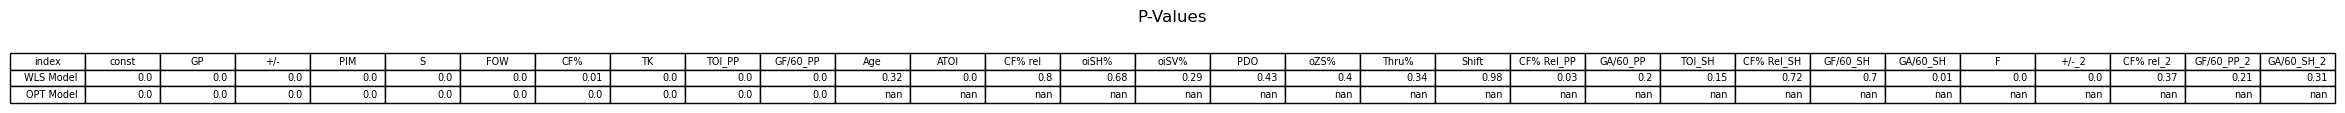

In [28]:
p_wls = model_wls.pvalues.to_frame().reset_index().rename({'index': 'Models', 0:'WLS Model'}, axis=1).round(2)
p_opt = model_opt.pvalues.to_frame().reset_index().rename({'index': 'Models', 0:'OPT Model'}, axis=1).round(2)

p_table = p_wls.merge(p_opt, on='Models', how='left').sort_values(by='OPT Model').set_index('Models').T.reset_index()

fig, ax = plt.subplots(figsize=(30,0.3))
ax.table(cellText=p_table.values, colLabels=p_table.columns).set_fontsize(15)
ax.axis('off')
ax.set_title('P-Values')

| Metrics  | WLS Model  | Optimized WLS Model  |
|---|---|---|
| MSE  | <span style="color: green;">12.59</span>  | <span style="color: red;">15.08</span>  | 
| RMSE  | <span style="color: green;">17.29</span> | <span style="color: red;">20.94</span>  | 
| R^2  | <span style="color: green;">0.906</span>  | <span style="color: red;">0.849</span>  | 
----------------------------
*Note: The WLS Model has a many values that are statistically insignificant

The high amount of statistically insignificant variables in the first WLS model indicates that those variables have a higher chance of "luck" affecting the model. Thus, even thought the model has a much higher r-squared, AIC and BIC, the optimized model captures the nature of the data and its relationships much better.

# Model Summary

__Explanatory Variable Glossary:__
| Variables | Description |
|-------------|--------------------|
| GP | Total amount of games played. |
| +/- | Difference between the amount scored by a team and by the opposing team while a player is on the ice. |
| PIM | Total amount of penalty minutes. |
| S | Total amount of shots on goal. |
| FOW | Total amount of faceoff wins. |
| CF% | Calculated as the sum of shots on goal, missed shots, and blocked shots over the shots against, missed shots against and blocked shots against at equal strength. |
| TK | Total amount of takeaways. |
| TOI_PP | Average time on ice while on power play. |
| GF/60_PP |Total amount of goals for while a player is on the ice, per 60 minutes of ice time during the power play. |

__Explanatory Variable Coefficients:__
|  Variables   |  Coefs    | Description      |
|--------|----------------|-------------------|
|const    |   4.66| The baseline amount of points is 4.66.  |
|GP        |  8.21| For every game played, the player gains 8.2 points. |
|+/-       |  10.19| For every +/-, the player is expected to score 10 more points. |
|PIM      |   1.55| For every PIM, the player is expected to score about 1.5 more points. |
|S        |   3.59| For every shot, the player is expected to score about 3.6 more points. |
|FOW      |   0.26| For every faceoff win, the player is expected to score about 0.3 more points. |
|CF%       |  -32.01|For every increase of CF%, the player is expected to score about 32 fewer points. |
|TK       |   4.31| For every takeaway, the player is expected to score about 4.3 more points.|
|TOI_PP    |  3.17| For every increase of time on ice during the power play, the player is expected to score about 3.2 more points.|
|GF/60_PP  |  12.01|For every increase of goals for per 60 minutes, the player is expected to score about 12 more points. |
-----
*The coefficents assume that every other variable is at 0.*